<h1>Hola muchachos y benvenido en el RECORDO LINKAGGIO<h1>
<h3>Per prima cosa dobbiamo fare il setup dell'ambiente<h3>
<h4>Nulla di complicato e se hai giá installato la libreria recordlinkage nel tuo ambiente python puoi saltare questo passaggio<h4>
<h5>Ma considera che ha anche queste dipendenze:
    numpy,
    pandas,
    scipy,
    sklearn,
    jellyfish,
    joblib,
Inoltre raccomandate sono:
    numexpr - accelerating certain numerical operations,
    bottleneck - accelerating certain types of nan evaluations<h5>


In [1]:
!pip install recordlinkage

<h2>Da qui inizia l'uso e costumo della libreria<h2>

# Record Linkage e Deduplicazione Aziende

## Introduzione  
In questo notebook, utilizziamo la libreria `recordlinkage` per identificare e unire duplicati in un dataset di aziende. Seguiremo i seguenti passaggi:  
1. **Normalizzazione dei dati**  (vedi normalize_company_name.ipynb)
2. **Blocchi per ridurre i confronti**  
3. **Confronto tra record**  
4. **Classificazione dei duplicati**  
5. **Aggregazione dei migliori dati**  

---
#### **Step 1: Importazione delle Librerie e del DataFrame**

In [3]:
import recordlinkage
from recordlinkage import Compare
from recordlinkage.preprocessing import clean
import pandas as pd

companies_df = pd.read_csv('../aziende_normalizzate.csv')

C:\Users\matte\AppData\Local\Temp\ipykernel_11844\4040003662.py:6: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  companies_df = pd.read_csv('../aziende_normalizzate.csv')


#### **Step 2: Creazione del blocco per la riduzione delle coppie candidate**

Il blocco serve a ridurre il numero di confronti tra righe, raggruppando insieme quelle che potrebbero appartenere alla stessa azienda. Per esempio, bloccheremo le righe con lo stesso nome azienda, città e paese.


In [4]:
indexer = recordlinkage.Index()
indexer.block(left_on=['company_name'])  #proviamo solo su normalizzazione

candidate_pairs = indexer.index(companies_df)

print(f'Numero di coppie candidate: {len(candidate_pairs)}')

Numero di coppie candidate: 39762


#### **Sicuramente questo metodo di blocking puó esser migliorato perché penso ci perdiamo un sacco di match peró é anche vero che se hanno questi valori uguali sicuro so uguali**
#### Le possibili migliorie sono 2 o normalizziamo meglio i nomi e poi mettiamo bloking solo su nomi, oppure non usiamo blocking ma facciamo direttamente compare usandolo come blocking
---

### **Step 3: Confronto delle coppie candidate**

# **Record Linkage: Calcolo delle Feature sui Candidate Pairs**
In questa sezione, calcoliamo le feature di similarità tra le coppie di aziende candidate (`candidate_pairs`) utilizzando la libreria `recordlinkage`.  

## **Passaggi:**
1. **Creazione del MultiIndex**  
   - Convertiamo `candidate_pairs` in un `MultiIndex`, necessario per la funzione `compare.compute()`.  

2. **Pulizia del DataFrame**  
   - Resettiamo l'indice di `companies_df` per garantire la corrispondenza corretta tra gli ID delle aziende.  
   - Riempiamo i valori NaN con stringhe vuote per evitare errori nel confronto.  
   - Convertiamo `foundation_year` in numerico (`int`) per evitare problemi di tipo di dati.  

3. **Definizione delle Funzioni di Confronto**  
   - Utilizziamo la classe `Compare()` per specificare le metriche di similarità:  
     - **`numeric`** → Confronto esatto per `foundation_year`.  
     - **`string` (Jaro-Winkler)** → Per `city` e `country`, che possono avere leggere variazioni ortografiche.  

4. **Esecuzione del Confronto**  
   - Applichiamo la funzione `compare.compute()` sull'intero dataset.  
   - Se il dataset è molto grande e il kernel dovesse crashare, è possibile dividere il calcolo in batch più piccoli.  

Se il kernel si arresta per problemi di memoria, possiamo adottare strategie di ottimizzazione, come il calcolo a blocchi o l'uso di `Dask` per il processamento parallelo.

In [15]:
candidate_pairs_index = pd.MultiIndex.from_tuples(candidate_pairs, names=['left', 'right'])

companies_df = companies_df.reset_index(drop=True)

companies_df = companies_df.fillna("")

if companies_df['foundation_year'].dtype != 'int64':
    companies_df['foundation_year'] = pd.to_numeric(companies_df['foundation_year'], errors='coerce').fillna(0).astype(int)

compare = Compare()
compare.numeric('foundation_year', 'foundation_year', label='foundation_year')
compare.string('city', 'city', method='jarowinkler', threshold=0.85, label='city')
compare.string('country', 'country', method='jarowinkler', threshold=0.85, label='country')

try:
    features = compare.compute(candidate_pairs_index, companies_df)
    display(features.head(10))
except Exception as e:
    print("Errore durante il calcolo delle feature sull'intero dataset:", e)

foundation_year  city  country
left right                                
1027 1026               1.0   0.0      1.0
1028 1026               1.0   0.0      1.0
     1027               1.0   1.0      1.0
1029 1026               1.0   0.0      0.0
     1027               1.0   0.0      0.0
     1028               1.0   0.0      0.0
1037 1036               1.0   0.0      1.0
1038 1036               1.0   0.0      0.0
     1037               1.0   0.0      0.0
1040 1039               1.0   0.0      1.0


---

### **Step 4: Filtraggio delle corrispondenze**

In [17]:
matches = features[features.sum(axis=1) > 1]

print(f'Numero di corrispondenze trovate: {len(matches)}')

matches.head()

Numero di corrispondenze trovate: 8593


foundation_year  city  country
left right                                
1027 1026               1.0   0.0      1.0
1028 1026               1.0   0.0      1.0
     1027               1.0   1.0      1.0
1037 1036               1.0   0.0      1.0
1040 1039               1.0   0.0      1.0

### **Step 5: Cobinazione righe**
Infine, possiamo deduplicare i dati aziendali combinando le righe corrispondenti. In questo esempio, prenderemo i valori più "affidabili" (ad esempio, il valore massimo per le colonne numeriche) per ogni gruppo di corrispondenze.

In [19]:
grouped_matches = matches.loc[matches.sum(axis=1).groupby(level=0).idxmax()]

grouped_matches.head(100)


,,foundation_year,city,country
left,right,,,
1027,1026,1.0,0.0,1.0
1028,1027,1.0,1.0,1.0
1037,1036,1.0,0.0,1.0
1040,1039,1.0,0.0,1.0
1048,1047,1.0,1.0,1.0
...,...,...,...,...
1861,1860,1.0,0.0,1.0
1884,1882,1.0,0.0,1.0
1901,1900,1.0,0.0,1.0


# **Ora dobbiamo mettere tutto insieme**

### Codice per deduplicazione e aggregazione dei dati

In questo codice, stiamo utilizzando le librerie **Pandas** e **NetworkX** per gestire e aggregare i dati aziendali duplicati. La libreria **NetworkX** ci permette di costruire un grafo delle connessioni tra aziende basate sui loro match, identificando i gruppi di duplicati tramite componenti connesse. Vediamo come funziona:

#### 1. **Costruzione del Grafo delle Connessioni**

NetworkX è una libreria Python utilizzata per la creazione, manipolazione e studio della struttura delle reti complesse. In questo caso, la stiamo utilizzando per costruire un grafo in cui ogni azienda è un **nodo**, e ogni coppia di aziende che fanno match è un **arco** tra di esse. Una volta costruito il grafo, possiamo utilizzare la funzione `connected_components` di NetworkX per identificare i **gruppi di aziende duplicate**. Ogni gruppo di aziende duplicate è una **componente connessa** nel grafo.

#### 2. **Assegnazione del Group ID**

Dopo aver trovato i gruppi di aziende duplicate, assegniamo un **ID unico (group_id)** a ciascun gruppo. Ogni azienda avrà associato il suo `group_id`, che verrà utilizzato per aggregare i dati.

#### 3. **Aggregazione dei Dati**

Per ciascun gruppo di duplicati, aggregheremo i dati come segue:
- **Numerici:** prendiamo il valore **massimo** (ad esempio, `foundation_year`).
- **Testo:** concatenamo i valori **unici** (ad esempio, città, paese, ecc.) separati da `" | "`.
- Rimuoviamo i valori **NaN** e manteniamo solo i valori effettivi.

#### 4. **Stampa dei Gruppi Aggregati**

Vogliamo anche stampare i gruppi che sono stati aggregati, ma solo quando il gruppo contiene **almeno 3 elementi**. Questo ci aiuta a concentrarci su quelli che potrebbero essere i gruppi più significativi o complessi.

In [30]:
import networkx as nx
# Funzione di aggregazione personalizzata
def merge_values(series):
    unique_values = set(series.dropna())  # Rimuove i NaN e prende solo i valori unici
    return ' | '.join(map(str, unique_values)) if len(unique_values) > 0 else ''  # Concatena i valori

# Creiamo il grafo dai match
G = nx.Graph()
G.add_edges_from(grouped_matches.index.tolist())

# Troviamo i gruppi di aziende duplicate
connected_components = list(nx.connected_components(G))

# Assegniamo un group_id a ogni azienda
duplicate_groups = {node: i for i, component in enumerate(connected_components) for node in component}

# Aggiungiamo il group_id al DataFrame originale
companies_df['group_id'] = companies_df.index.map(duplicate_groups)

# Funzione per stampare le righe aggregate
def print_aggregated_rows(group_id, group_data):
    if len(group_data) >= 3:  # Stampa solo se il gruppo contiene almeno 3 aziende
        print(f"\nAggregazione del gruppo {group_id} (con {len(group_data)} elementi):")
        group_data = group_data.reset_index()  # Reset dell'indice per accedere alle colonne come 'id'
        print(group_data[['company_name', 'city', 'country', 'address']])  # Stampa alcune colonne d'esempio

# Raggruppiamo per group_id e applichiamo l’aggregazione
final_df = companies_df.groupby('group_id').agg(merge_values).reset_index()

# Rimuoviamo il 'group_id' dal DataFrame finale se non vogliamo che compaia
final_df = final_df.drop(columns=['group_id'])

# Stampiamo alcune righe aggregate
for group_id, group_data in companies_df.groupby('group_id'):
    print_aggregated_rows(group_id, group_data)

# Salviamo il risultato in un CSV
final_df.to_csv("deduplicated_companies.csv", index=False)

# Stampiamo un'anteprima del risultato finale
display(final_df.head())



Aggregazione del gruppo 0.0 (con 3 elementi):
        company_name     city        country                address
0  1-800-flowers.com           united states                       
1  1-800-flowers.com  jericho  united states  2 jericho plz ste 200
2  1-800-flowers.com  jericho  united states  2 jericho plz ste 200

Aggregazione del gruppo 13.0 (con 4 elementi):
  company_name        city        country    address
0           3m              united states           
1           3m              united states           
2           3m              united states           
3           3m  saint paul  united states  3m center

Aggregazione del gruppo 21.0 (con 3 elementi):
  company_name city country address
0      7layers        italy        
1      7layers        italy        
2      7layers        italy        

Aggregazione del gruppo 35.0 (con 3 elementi):
  company_name city  country address
0  aareal bank       germany        
1  aareal bank       germany        
2  aareal bank   

,company_id,company_name,trade_name,industry,sector,categories,company_status,company_type,headquarters,address,...,twitter,pinterest,instagram,investors,region,notes_or_description,normalized_name,modified,normalized_country,city_translate
0,c11c4decba8742b8853058c68875e0b6 | 3694 | 1804,1-800-flowers.com,| 1-800-flowers.com,,,"| ['Consumer Cyclical', 'Retail']",,,,| 2 jericho plz ste 200,...,,,,,,| headquarter,1-800-flowers.com,False | True,united states,| jericho
1,e33d30e1d309429198c1f23eafcb88db | c1312a8c4da...,10x genomics,,,,"['Genomics', 'Biotech'] | ['Healthcare', 'Medi...",,,,,...,,,,,,,10x genomics,True,united states,
2,53b870f2377d436c9f8c8bf61fc85cdd | 2feb10d62d3...,11,,,,"['Telecommunication', 'Internet'] | ['Communic...",,,,,...,,,,,,,11,True,germany,
3,4300 | 1500,123-reg,,,,,,,,"5th floor the shipping building old viny, 252-...",...,,,,,,headquarter,123-reg,False,united kingdom,hayes
4,2862294f65604246b1233a9e34ec249e | 380a0b3b918...,1st source,,,,"['Banks', 'Financial services'] | ['Financial ...",,,,,...,,,,,,,1st source,True,united states,


### Analisi della distribuzione dei duplicati

In questa sezione, generiamo un grafico che ci aiuta a esplorare meglio la distribuzione dei duplicati.

#### 1. **Distribuzione delle dimensioni dei gruppi di duplicati**

Abbiamo creato un istogramma per visualizzare la distribuzione delle dimensioni dei gruppi di duplicati. Ogni barra dell'istogramma rappresenta un gruppo di duplicati con una determinata dimensione, mostrando quanti gruppi hanno una dimensione specifica (escludendo i gruppi che contano solo una riga).

Abbiamo escluso i gruppi con solo una riga per concentrare l'analisi sui gruppi che presentano effettivamente duplicati, in modo da avere una visione più significativa dei dati.

#### 2. **Distribuzione dei duplicati per paese**

Un altro grafico mostra la distribuzione dei duplicati per paese, evidenziando in quale paese si concentrano maggiormente i duplicati. Questo grafico a barre ci consente di vedere quali paesi hanno un numero maggiore di duplicati e se ci sono tendenze geografiche nei dati.


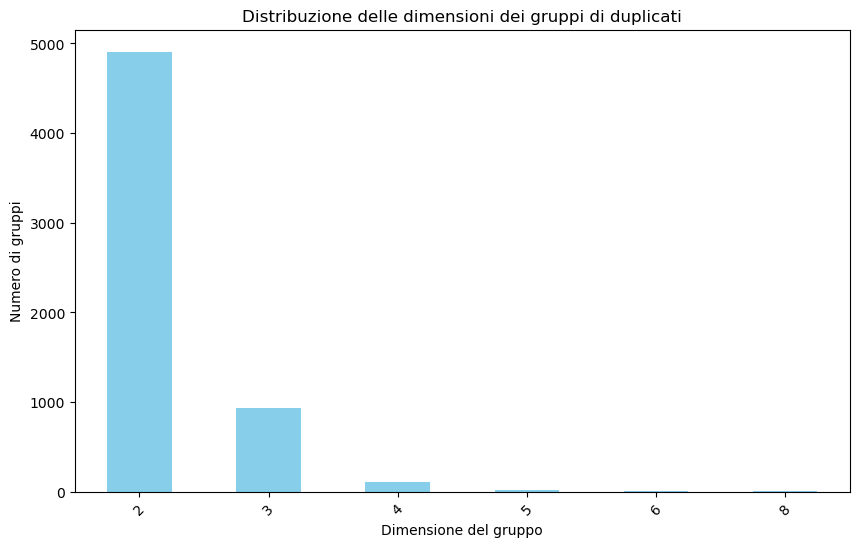

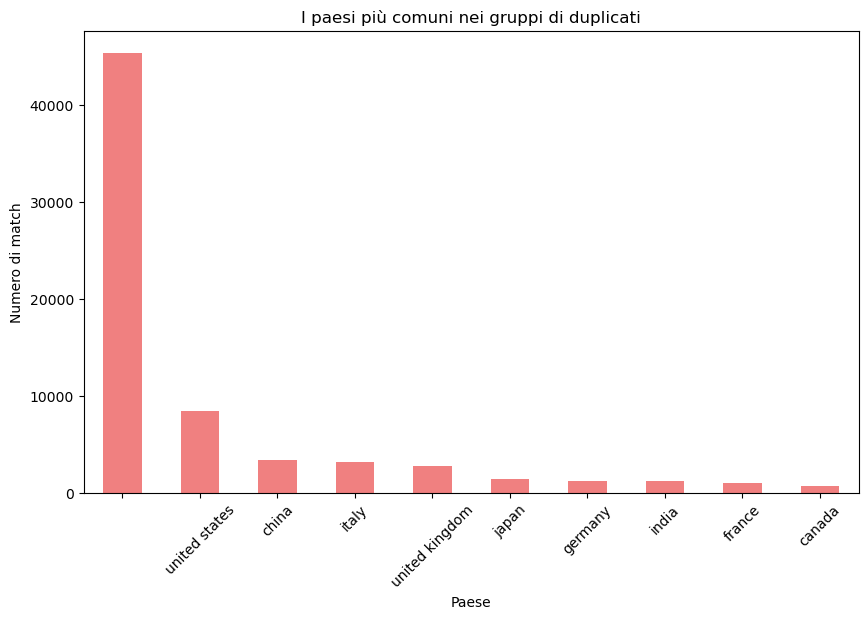

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns


# 1. Grafico a barre (istogramma) della distribuzione delle dimensioni dei gruppi di duplicati
group_sizes = companies_df.groupby('group_id').size()

# Escludiamo i gruppi con solo 1 elemento
group_sizes_filtered = group_sizes[group_sizes > 1]

# Creiamo l'istogramma delle dimensioni dei gruppi
plt.figure(figsize=(10, 6))
group_sizes_filtered.value_counts().sort_index().plot(kind='bar', color='skyblue')

# Aggiungiamo il titolo e le etichette
plt.title('Distribuzione delle dimensioni dei gruppi di duplicati')
plt.xlabel('Dimensione del gruppo')
plt.ylabel('Numero di gruppi')
plt.xticks(rotation=45)
plt.show()



# Paese
country_counts = companies_df['country'].value_counts()
plt.figure(figsize=(10, 6))
country_counts.head(10).plot(kind='bar', color='lightcoral')
plt.title('I paesi più comuni nei gruppi di duplicati')
plt.xlabel('Paese')
plt.ylabel('Numero di match')
plt.xticks(rotation=45)
plt.show()
